In [24]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from sys import path
path.append('..')
path.append('../stationsim')

import ffmpeg
from stationsim.stationsim_model import Model
from stationsim.ukf import *

In [11]:
"""
width - corridor width
height - corridor height
pop_total -population total
entrances - how many entrances
entrance speed- mean entry speed for agents
exits - how many exits
exit_space- how wide are exits 
speed_min - minimum agents speed to prevent ridiculuous iteration numbers
speed_mean - desired mean of normal distribution of speed of agents
speed_std - as above but standard deviation
speed_steps - how many levels of speed between min and max for each agent
separation - agent radius to determine collisions
wiggle - wiggle distance
batch_iterations - how many model steps to do as a maximum
3 do_ bools for saving plotting and animating data. 
"""
model_params = {
        'pop_total': 10,

        'width': 400,
        'height': 200,

        'gates_in': 3,
        'gates_out': 2,
        'gates_space': 1,
        'gates_speed': 1,

        'speed_min': .2,
        'speed_mean': 1,
        'speed_std': 1,
        'speed_steps': 3,

        'separation': 5,
        'max_wiggle': 1,

        'step_limit': 3600,

        'do_history': True,
        'do_print': True,
    }
"""
!!may be worth changing these to take noise matrices rather than a scalar to generate said matrix
Sensor_Noise - how reliable are measurements H_x. lower value implies more reliable.
Process_Noise - how reliable is prediction fx lower value implies more reliable

sample_rate - how often to update kalman filter. higher number gives smoother predictions. lowest is 1.
do_restrict - restrict to a proportion prop of the agents being observed
do_animate - bools for doing animations of agent/wiggle aggregates
do_wiggle_animate
do_density_animate
do_pair_animate
prop - proportion of agents observed. this is a floor function that rounds the proportion 
    DOWN to the nearest intiger number of agents. 1 is all <1/pop_total is none

heatmap_rate - after how many updates to record a frame
bin_size - square sizes for aggregate plots,
do_batch - do batch processing on some pre-recorded truth data.
"""

filter_params = {      

        "Sensor_Noise":  1, 
        "Process_Noise": 1, 
        'sample_rate': 1,
        "do_restrict": True, 
        "do_animate": True,
        "do_wiggle_animate": False,
        "do_density_animate":True,
        "do_pair_animate":False,
        "prop": 0.5,
        "heatmap_rate": 1,
        "bin_size":10,
        "do_batch":False,
        "do_unobserved":False
        }

"""
a - alpha between 1 and 1e-4 typically determines spread of sigma points.
b - beta set to 2 for gaussian. determines trust in prior distribution.
k - kappa usually 0 for state estimation and 3-dim(state) for parameters.
    not 100% sure what kappa does. think its a bias parameter.
d_rate - data assimilotion rate every "d_rate model steps recalibrate UKF positions with truth. not added yet
!! might be worth making an interactive notebook that varies these. for fun
"""

ukf_params = {

        "a":1,
        "b":2,
        "k":0,
        "d_rate" : 10, 

        }



	Iteration: 0/3600
	Iteration: 100/3600
	Iteration: 200/3600
	Iteration: 300/3600
	Iteration: 400/3600
	Iteration: 500/3600
	Iteration: 600/3600
	Iteration: 700/3600
	Iteration: 800/3600
	Iteration: 900/3600
	Iteration: 1000/3600
	Iteration: 1100/3600
	Iteration: 1200/3600
0:19:44.042763


../stationsim/ukf.py:767: RuntimeWarning: Mean of empty slice
  time_means = np.nanmean(c,axis=1)


3
0


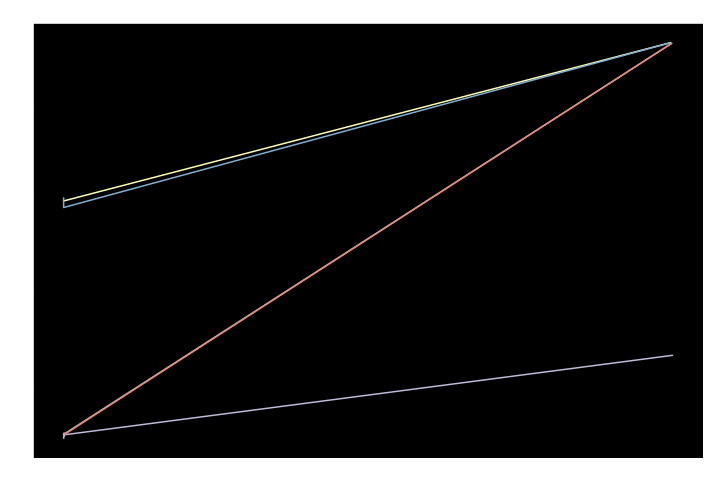

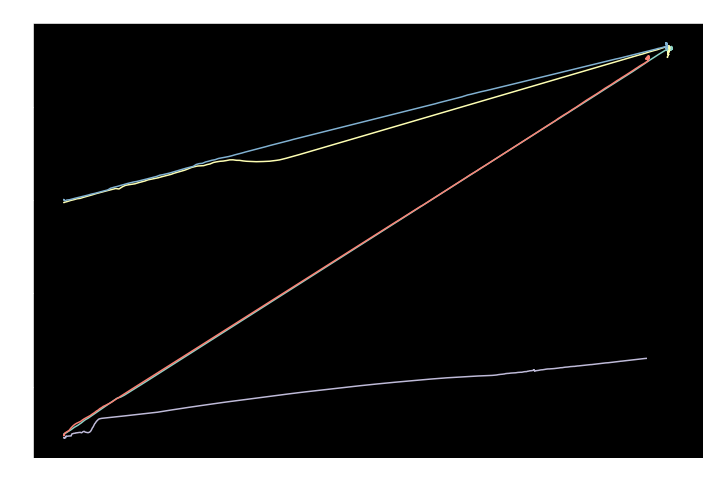

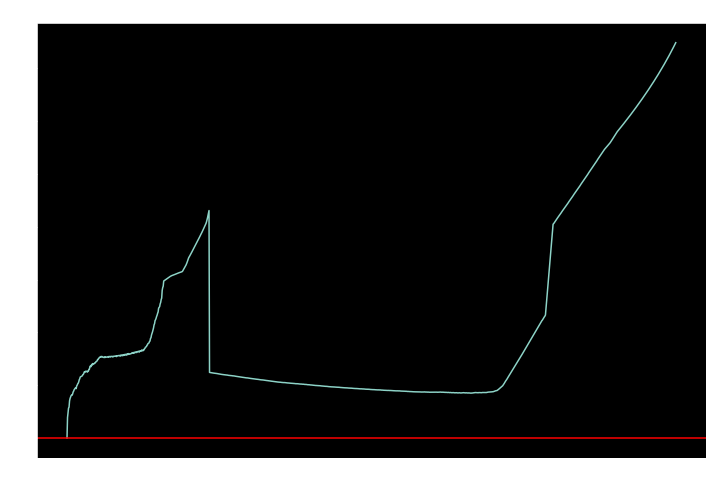

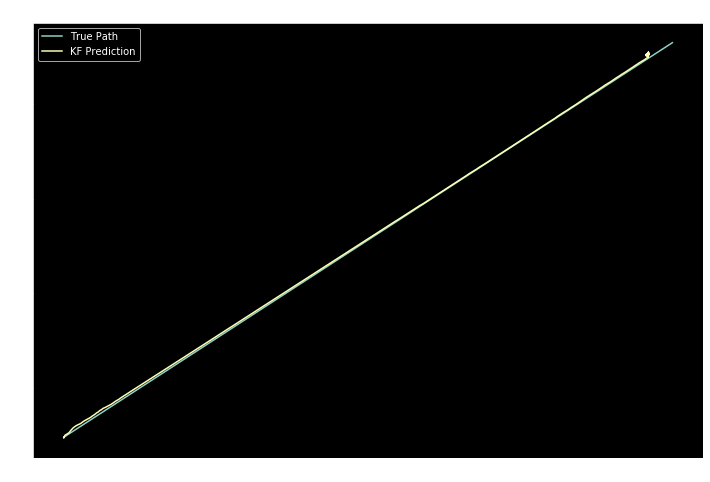

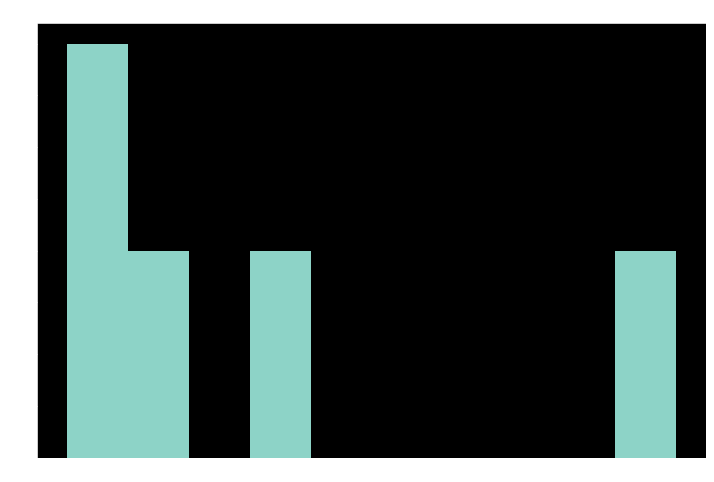

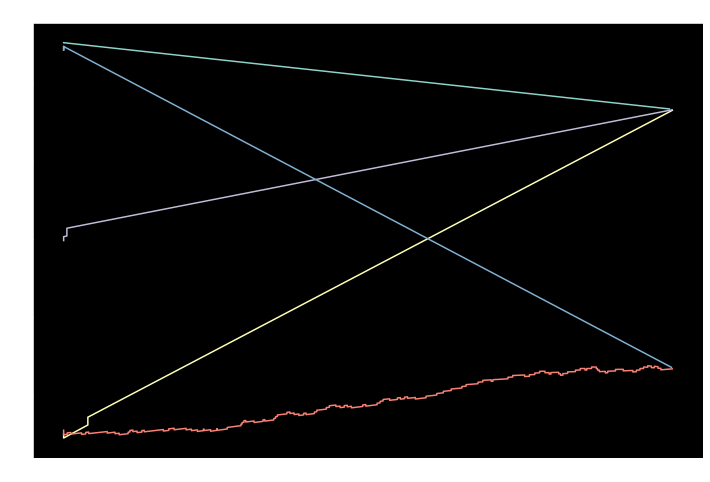

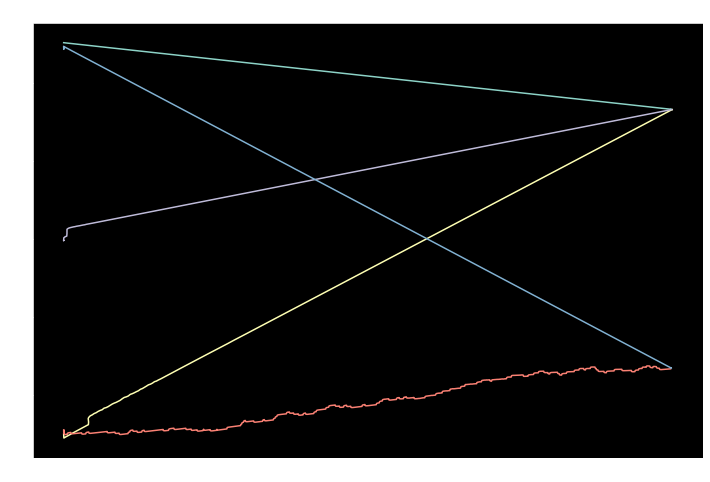

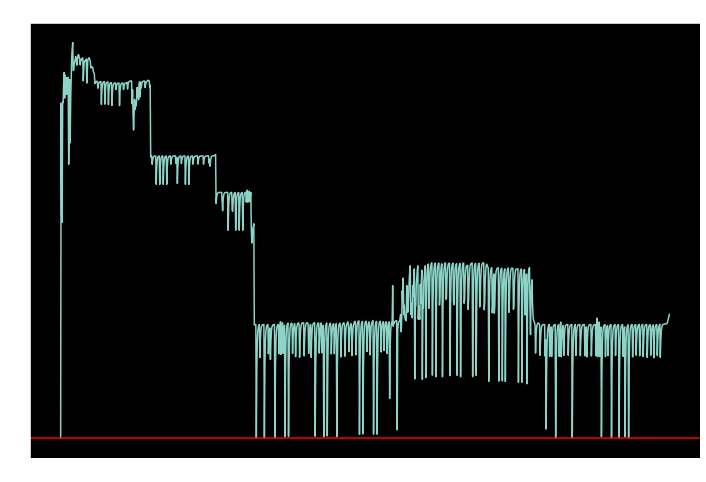

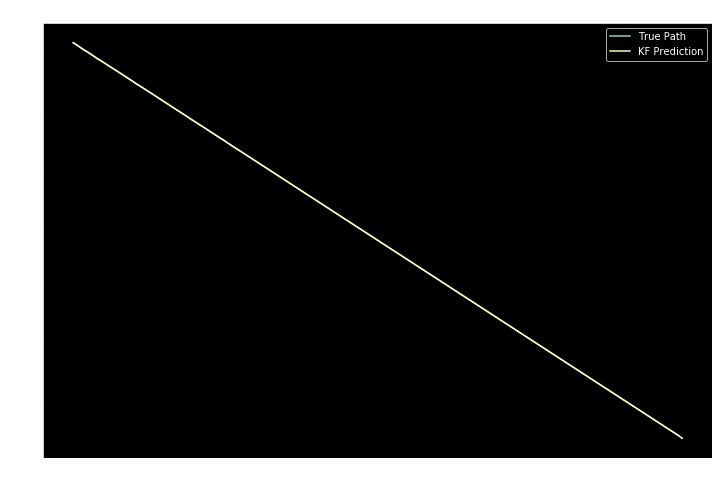

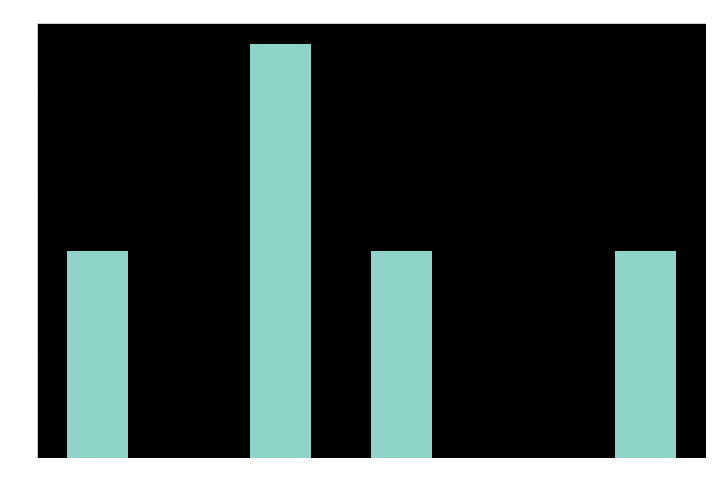

In [23]:
"initiate StationSim"
base_model = Model(**model_params)
"initiate UKF"
u = ukf_ss(model_params = model_params,filter_params = filter_params,ukf_params = ukf_params,base_model=base_model)
"run UKF main. iterate station sim and track agent locations"
u.main()
actual,preds= u.data_parser(True)

"initiate plot class using final instance of UKF. easier to do this that import numerous variables"
plts = plots(u)

"diagnostic plots, error matrices, and MAE over time"
if filter_params["prop"]<1 or filter_params["do_unobserved"]:
    distances,t_mean = plts.diagnostic_plots(actual,preds,False,False) #unobserved
distances2,t_mean2 = plts.diagnostic_plots(actual,preds,True,False) #observed

In [ ]:
"NOT WORKING YET "
plts = plots(u)
if filter_params["do_animate"]:
    plts.pair_frames(actual,preds)
    plts.heatmap(actual,preds)
    plts.difference_frames(actual,preds)
    

In [22]:
u.model_params["width"]

400

In [4]:
from matplotlib.patches import Ellipse
def ukf_ex(a,b,k):
    def fx(x):
        x+= np.ones(x.shape)
        return x
    
    def hx(x):
        return x
    ukf_params = {

        "a":a,
        "b":b,
        "k":k,
        "d_rate" : 10, 

        }
    
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]
    print(ukf_params)
    n_agents = 1
    np.random.seed(12)
    n_steps=5
    ys = np.zeros((n_steps+1,2*n_agents))
    for i in range(1,int(ys.shape[0])):
        ys[i,:] = ys[i-1,:]+ np.ones(2*n_agents) + 0.25*np.random.normal(size=ys.shape[1])


    Q = np.eye(2*n_agents)
    R = np.eye(2*n_agents)
    P = np.array([[1,0],[0,1]])

    xs = []
    Ps=[]
    xs.append(ys[0,:])
    u2 = ukf(ukf_params,ys[0,:],fx,hx,P,Q,R)
    for j in range(1,n_steps+1):
        u2.predict()
        y = ys[j,:]
        u2.update(y)
        xs.append(u2.x)
        Ps.append(u2.P)
    
        
    res = np.array(xs)-np.array(ys)
    distances = np.zeros((n_steps,n_agents))
    for i in range(n_agents):
        for j in range(n_steps+1):
            distances[j:,i] = dist.euclidean(res[j,(2*i)],res[j,(2*i)+1])
    import matplotlib.pyplot as plt
    xs=np.array(xs)[1:,:]
    ys=np.array(ys)[1:,:]
    
    nstd = 1
    f = plt.figure(figsize=(12,12))
    ax = plt.subplot(111, aspect='equal')
    sigmas = u2.Sigmas(u2.x,u2.P)
    ax.scatter(sigmas[0,:],sigmas[1,:],color = "yellow")
    ax.scatter(ys[4,0],ys[4,1],color="r")
    vals, vecs = eigsorted(u2.P)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    w, h = 2 * nstd * np.sqrt(vals)
    ell = Ellipse(xy=(u2.x[0],u2.x[1]),width=w, height=h,angle=theta, color="cyan",linewidth=4)
    ell.set_facecolor('none')
    ax.add_artist(ell)
    
    vals, vecs = eigsorted(np.eye(2)*5/16)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    w, h = 2 * nstd * np.sqrt(vals)
    ell2 = Ellipse(xy=(ys[4,0],ys[4,1]),width=w, height=h,angle=theta, color='orangered',linewidth=4)
    ell2.set_facecolor('none')
    ax.add_artist(ell2)
    
    
    ax.set_xlim([3,7])
    ax.set_ylim([3,8])
    plt.show()
 

def ensemble_ex(n):
    np.random.seed(12)
    pf_ys=[]
    n_particles = n
    n_steps=5
    n_agents=1
    truth_ys  = np.zeros((n_steps+1,2*n_agents))
    for i in range(1,int(truth_ys.shape[0])):
        truth_ys[i,:] = truth_ys[i-1,:]+ np.ones(2*n_agents) + 0.5*np.random.normal(size=truth_ys.shape[1])

    for _ in range(n_particles):
        ys = np.zeros((n_steps+1,2*n_agents))
        for i in range(1,int(ys.shape[0])):
            ys[i,:] = ys[i-1,:]+ np.ones(2*n_agents) + 0.5*np.random.normal(size=ys.shape[1])
        pf_ys.append(ys[-1,:])

    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]
    pf_ys=np.vstack(pf_ys)
    x = pf_ys[:,0]
    y= pf_ys[:,1]

    distances = np.sqrt((x-truth_ys[-1,0])**2+(y-truth_ys[-1,1])**2)
    index = np.where(distances<2)
    x= x[index]
    y=y[index]
    nstd=1
    f = plt.figure(figsize=(12,12))
    ax = plt.subplot(111, aspect='equal')        
    ax.scatter(x,y,color="yellow")
    ax.scatter(truth_ys[-1,0],truth_ys[-1,1], color='orangered')
    vals, vecs = eigsorted(np.cov(x,y))
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    w, h = 2 * nstd * np.sqrt(vals)
    ax.scatter(np.mean(x),np.mean(y), color='skyblue')
    ell = Ellipse(xy=(np.mean(x),np.mean(y)),width=w, height=h,angle=theta, color='cyan',linewidth=4.0)
    ell.set_facecolor('none')
    ax.add_artist(ell)

    vals, vecs = eigsorted(np.eye(2)*5/4)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    w, h = 2 * nstd * np.sqrt(vals)
    ell2 = Ellipse(xy=(truth_ys[-1,0],truth_ys[-1,1]),width=w, height=h,angle=theta, color='orangered',linewidth=4.0)
    ell2.set_facecolor('none')
    ax.add_artist(ell2)

    ax.set_xlim([3,7])
    ax.set_ylim([3,8])
    plt.show()


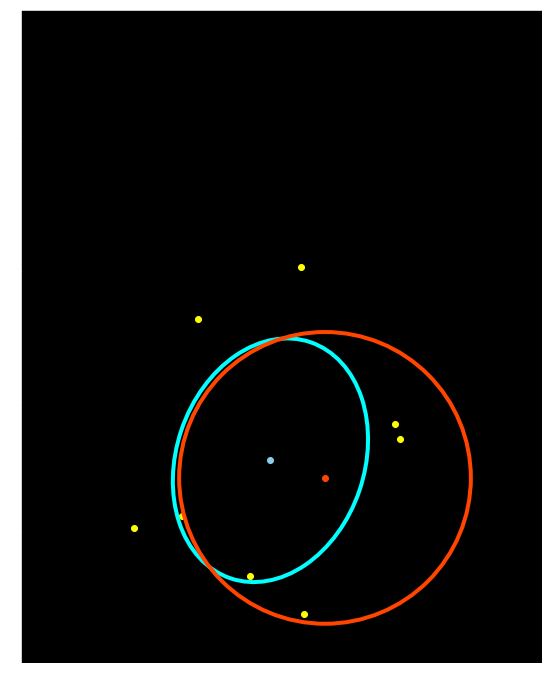

In [5]:
y = interactive(ukf_ex,a=[1,0.1,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,2,3],b =[2,0,0.5,1,1.5,2,2.5,3],k=range(5))
display(y)
z = interactive(ensemble_ex,n = [10,100,1000,10000,100000,1000000])
display(z)